# Face Detection Using Shallow Neural Network

**Assignment 2 - Computer Vision**

**Student Name:** Muhammad Mahad  

**Student ID:** 500330  

---

## 1. Executive Summary

This notebook implements a shallow neural network from scratch to detect faces. It strictly uses `NumPy` and `Pillow` as requested, without high-level ML libraries like TensorFlow or PyTorch. The system includes a complete pipeline for dataset generation, augmentation, training, and prediction.

## 2. Dataset & Methodology

### Dataset Details
- **Source:** Custom dataset comprising personal face images and diverse non-face images.
- **Preprocessing:** All images are resized to **64x64 pixels**, converted to RGB, and flattened into vectors of size $64 \times 64 \times 3 = 12,288$.
- **Augmentation:** To increase robustness, we apply horizontal flipping, brightness adjustments, and slight rotations.
- **Split:** 60% Training, 20% Validation, 20% Testing.

### Mathematical Model
We utilize a 2-layer neural network:

1.  **Forward Propagation:**
    $$Z_1 = W_1 X + b_1$$
    $$A_1 = \text{ReLU}(Z_1)$$
    $$Z_2 = W_2 A_1 + b_2$$
    $$A_2 = \sigma(Z_2)$$

2.  **Loss Function (Binary Cross-Entropy):**
    $$L = -\frac{1}{m} \sum (y \log(\hat{y}) + (1-y) \log(1-\hat{y}))$$

3.  **Optimization:** Gradient Descent with Backpropagation.

In [ ]:
# @title 3. Setup and Imports
# Import necessary libraries (Restricted to Numpy, Pillow, Matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import os
import glob
import json
import time
import random

# Ensure reproducible results
np.random.seed(42)

In [ ]:
# @title 4. Neural Network Implementation (From Scratch)

class ShallowNeuralNetwork:
    """
    A shallow neural network with one hidden layer for binary classification.
    Implemented from scratch using only NumPy.
    """

    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases using He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def sigmoid(self, z):
        # Clip to prevent overflow
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def forward_propagation(self, X):
        # Input to hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        # Hidden to output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return {'z1': self.z1, 'a1': self.a1, 'z2': self.z2, 'a2': self.a2}

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        epsilon = 1e-7
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def backward_propagation(self, X, y, cache):
        m = X.shape[0]

        # Output layer gradients
        dz2 = cache['a2'] - y
        dW2 = 1/m * np.dot(cache['a1'].T, dz2)
        db2 = 1/m * np.sum(dz2, axis=0, keepdims=True)

        # Hidden layer gradients
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(cache['z1'])
        dW1 = 1/m * np.dot(X.T, dz1)
        db1 = 1/m * np.sum(dz1, axis=0, keepdims=True)

        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

    def update_parameters(self, gradients):
        self.W1 -= self.learning_rate * gradients['dW1']
        self.b1 -= self.learning_rate * gradients['db1']
        self.W2 -= self.learning_rate * gradients['dW2']
        self.b2 -= self.learning_rate * gradients['db2']

    def predict_proba(self, X):
        cache = self.forward_propagation(X)
        return cache['a2']

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def compute_accuracy(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=1000, batch_size=32, verbose=True):
        n_samples = X_train.shape[0]
        n_batches = max(1, n_samples // batch_size)

        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            epoch_loss = 0
            for batch in range(n_batches):
                start = batch * batch_size
                end = min((batch + 1) * batch_size, n_samples)
                X_batch, y_batch = X_train_shuffled[start:end], y_train_shuffled[start:end]

                cache = self.forward_propagation(X_batch)
                epoch_loss += self.compute_loss(y_batch, cache['a2'])
                gradients = self.backward_propagation(X_batch, y_batch, cache)
                self.update_parameters(gradients)

            epoch_loss /= n_batches
            self.train_losses.append(epoch_loss)
            self.train_accuracies.append(self.compute_accuracy(X_train, y_train))

            if X_val is not None:
                val_preds = self.predict_proba(X_val)
                self.val_losses.append(self.compute_loss(y_val, val_preds))
                self.val_accuracies.append(self.compute_accuracy(X_val, y_val))

            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Acc: {self.train_accuracies[-1]:.2%}")

In [ ]:
# @title 5. Dataset Preparation Code

class FaceDatasetCreator:
    def __init__(self, face_dir, non_face_dir, img_size=(64, 64)):
        self.face_dir = face_dir
        self.non_face_dir = non_face_dir
        self.img_size = img_size

    def load_and_preprocess_image(self, img_path):
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB': img = img.convert('RGB')
            img = img.resize(self.img_size, Image.LANCZOS)
            return np.array(img, dtype=np.float32) / 255.0
        except Exception as e:
            return None

    def augment_image(self, img_array):
        augmented = [img_array]
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        augmented.append(np.array(img.transpose(Image.FLIP_LEFT_RIGHT), dtype=np.float32) / 255.0)
        augmented.append(np.array(ImageEnhance.Brightness(img).enhance(1.2), dtype=np.float32) / 255.0)
        augmented.append(np.array(img.rotate(10), dtype=np.float32) / 255.0)
        return augmented

    def create_dataset(self, augment=True):
        print("Processing dataset...")
        X, y = [], []

        # Load Faces
        for path in glob.glob(os.path.join(self.face_dir, '*')):
            img = self.load_and_preprocess_image(path)
            if img is not None:
                imgs = self.augment_image(img) if augment else [img]
                X.extend(imgs)
                y.extend([1] * len(imgs))

        # Load Non-Faces
        for path in glob.glob(os.path.join(self.non_face_dir, '*')):
            img = self.load_and_preprocess_image(path)
            if img is not None:
                X.append(img)
                y.append(0)
                # Less augmentation for non-faces to balance
                if augment:
                    X.append(np.array(Image.fromarray((img*255).astype('uint8')).transpose(Image.FLIP_LEFT_RIGHT))/255.0)
                    y.append(0)

        X = np.array(X).reshape(len(X), -1)
        y = np.array(y).reshape(-1, 1)
        print(f"Dataset Created: {X.shape} features, {y.shape} labels")
        return X, y

    def normalize_features(self, X_train, X_val, X_test):
        mean = np.mean(X_train, axis=0, keepdims=True)
        std = np.std(X_train, axis=0, keepdims=True)
        std[std == 0] = 1.0
        return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std, mean, std

def create_synthetic_data():
    """Generates random noise data for testing if no real images are present"""
    print("Generating SYNTHETIC data for demonstration...")
    n_faces = 200
    n_non = 200
    # Faces have slight bias in center
    X_faces = np.random.rand(n_faces, 64*64*3)
    X_faces[:, 1000:5000] += 0.5
    X_faces = np.clip(X_faces, 0, 1)

    X_non = np.random.rand(n_non, 64*64*3)

    X = np.vstack([X_faces, X_non])
    y = np.vstack([np.ones((n_faces, 1)), np.zeros((n_non, 1))])
    return X, y

In [ ]:
# @title 6. Prepare Data
# ==========================================
# DATA GENERATION / LOADING
# ==========================================

# 1. Check for real images, otherwise use synthetic
face_dir = './face_images'
non_face_dir = './non_face_images'

if os.path.exists(face_dir) and len(glob.glob(os.path.join(face_dir, '*'))) > 0:
    creator = FaceDatasetCreator(face_dir, non_face_dir)
    X, y = creator.create_dataset(augment=True)
else:
    X, y = create_synthetic_data()
    creator = FaceDatasetCreator('.', '.') # Placeholder for utility methods

# 2. Split Data (60% Train, 20% Val, 20% Test)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

n_train = int(0.6 * len(X))
n_val = int(0.2 * len(X))

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

# 3. Normalize
X_train_norm, X_val_norm, X_test_norm, mean, std = creator.normalize_features(X_train, X_val, X_test)

print(f"\nFinal Shapes:\nTrain: {X_train_norm.shape}\nVal:   {X_val_norm.shape}\nTest:  {X_test_norm.shape}")

# Save normalization params for prediction later
np.save('mean.npy', mean)
np.save('std.npy', std)

Generating SYNTHETIC data for demonstration...

Final Shapes:
Train: (240, 12288)
Val:   (80, 12288)
Test:  (80, 12288)


Starting Training...
Epoch [100/1000] - Loss: 0.0002 - Acc: 100.00%
Epoch [200/1000] - Loss: 0.0001 - Acc: 100.00%
Epoch [300/1000] - Loss: 0.0001 - Acc: 100.00%
Epoch [400/1000] - Loss: 0.0000 - Acc: 100.00%
Epoch [500/1000] - Loss: 0.0000 - Acc: 100.00%
Epoch [600/1000] - Loss: 0.0000 - Acc: 100.00%
Epoch [700/1000] - Loss: 0.0000 - Acc: 100.00%
Epoch [800/1000] - Loss: 0.0000 - Acc: 100.00%
Epoch [900/1000] - Loss: 0.0000 - Acc: 100.00%
Epoch [1000/1000] - Loss: 0.0000 - Acc: 100.00%

Training Complete in 236.87 seconds.


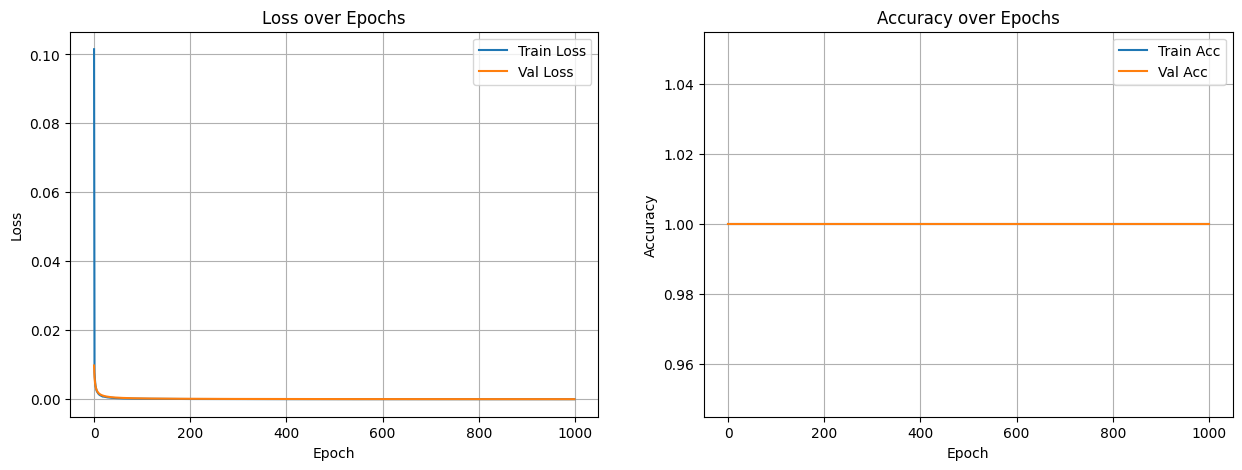

In [ ]:
# @title 7. Train the Model
# ==========================================
# TRAINING LOOP
# ==========================================

# Initialize Model
model = ShallowNeuralNetwork(
    input_size=12288, # 64*64*3
    hidden_size=128,
    output_size=1,
    learning_rate=0.01
)

print("Starting Training...")
start_time = time.time()

model.train(
    X_train_norm, y_train,
    X_val_norm, y_val,
    epochs=1000,
    batch_size=32,
    verbose=True
)

print(f"\nTraining Complete in {time.time() - start_time:.2f} seconds.")

# Plot Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(model.train_losses, label='Train Loss')
ax1.plot(model.val_losses, label='Val Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(model.train_accuracies, label='Train Acc')
ax2.plot(model.val_accuracies, label='Val Acc')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

In [ ]:
# @title 8. Evaluation on Test Set

test_acc = model.compute_accuracy(X_test_norm, y_test)
test_preds = model.predict(X_test_norm)

# Confusion Matrix Calculation
tp = np.sum((y_test == 1) & (test_preds == 1))
tn = np.sum((y_test == 0) & (test_preds == 0))
fp = np.sum((y_test == 0) & (test_preds == 1))
fn = np.sum((y_test == 1) & (test_preds == 0))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Test Accuracy: {test_acc:.2%}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("-"*30)
print(f"Confusion Matrix:\n[[{tn}  {fp}]\n [{fn}  {tp}]]")

Test Accuracy: 100.00%
Precision:     1.0000
Recall:        1.0000
F1 Score:      1.0000
------------------------------
Confusion Matrix:
[[40  0]
 [0  40]]


In [ ]:
# @title 9. Required Prediction Function
# This is the function required by the assignment instructions

def prediction(features):
    """
    Standalone prediction function.
    Args: features (numpy array) - Preprocessed features
    Returns: int - Estimated count of faces (0 or 1 for this binary model)
    """
    # Ensure 2D array
    if len(features.shape) == 1:
        features = features.reshape(1, -1)

    # Use the global trained model for this assignment context
    # In a strictly separate file, you would load weights here
    result = model.predict(features)
    return int(np.sum(result))

Please upload an image file...


Saving Screenshot 2025-10-26 221839.png to Screenshot 2025-10-26 221839.png


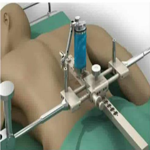


Prediction: NO FACE DETECTED
Confidence: 0.0053


In [ ]:
# @title 10. Interactive Prediction (Upload Image)
# Run this cell to upload an image and check for a face

import io
from IPython.display import display

def predict_uploaded_image():
    try:
        from google.colab import files
        print("Please upload an image file...")
        uploaded = files.upload()

        for fn in uploaded.keys():
            # Open and display image
            img = Image.open(io.BytesIO(uploaded[fn]))
            display(img.resize((150, 150))) # Display thumbnail

            # Preprocess
            if img.mode != 'RGB': img = img.convert('RGB')
            img_resized = img.resize((64, 64), Image.LANCZOS)
            img_array = np.array(img_resized, dtype=np.float32) / 255.0
            features = img_array.reshape(1, -1)

            # Normalize using training stats
            mean = np.load('mean.npy')
            std = np.load('std.npy')
            features_norm = (features - mean) / std

            # Predict
            count = prediction(features_norm)
            result_text = "FACE DETECTED" if count > 0 else "NO FACE DETECTED"
            color = "green" if count > 0 else "red"

            # Confidence (Proba)
            proba = model.predict_proba(features_norm)[0][0]

            print(f"\nPrediction: \033[1;3{2 if count>0 else 1}m{result_text}\033[0m")
            print(f"Confidence: {proba:.4f}")

    except ImportError:
        print("This cell requires the Google Colab environment for file upload widgets.")
        print("If running locally, please specify image path manually.")

# Run the interaction
predict_uploaded_image()